In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import pickle
from copy import deepcopy

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from itertools import permutations, combinations

from datasets import Data_From_File
from sklearn.metrics import ndcg_score
from perms import Gk

import matplotlib.pyplot as plt

In [2]:
class Data_for_torch(Dataset, Data_From_File):
    
    def __init__(self, file, which = 0):
        
        self.data = pd.DataFrame(Data_From_File.open_file(file)[which]).drop('doc_id', axis = 1)
        self.dict_data = self.data.set_index('query_id').T.to_dict('list')
        self.keys = list(self.dict_data.keys())
        
    def __len__(self):
        return len(self.dict_data)
        
    def __getitem__(self, idx):
        key = self.keys[idx]
        return self.dict_data[key]

In [3]:
train_data = Data_for_torch('datas_full_10k_1.pkl', which = 0)
vali_data = Data_for_torch('datas_full_10k_1.pkl', which = -1)

In [4]:
train_loader = DataLoader(train_data, shuffle=True)
test_loader = DataLoader(vali_data, batch_size=1)

In [5]:
class ListNet(nn.Module):
    def __init__(self,inp_size = 136, out_size = 1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(inp_size, 256),
            nn.ReLU(),
            nn.Linear(256,256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,out_size),
            
            )
        
    def forward(self, X):
        output = self.model(X).squeeze()
        return output
    
    
    # dict_y = {}

In [ ]:
def loss(p,y):
    return torch.sum(y * torch.log(y / (p + 1e-6)))

def vali(vali_loader, model):
    model.eval()
    
    device = next(model.parameters()).device
    acc = 0
    length = len(vali_loader)
    
    for batch in vali_loader:
        X = batch[0].to(device)
        y = batch[1].cpu().view(-1).numpy()
            
        preds = model(X.float()).view(-1).detach().cpu().numpy()
        
        try:
            acc += ndcg_score([list(y)], [list(preds)])
        except:
            length -= 1
            continue
            
    return acc / length

def train(train_dataloader, test_dataloader, model, loss_fn, optimizer, sheluder, epochs, is_test = True, is_sheluder = False ):
    device = next(model.parameters()).device
    
    pred_probs = nn.Softmax(dim = -1)
    y_probs = nn.Softmax(dim = -1)
    
    train_loss = []
    metric = []
    
    
    
    for i in range(epochs):
        loss_epoch = 0
        
        model.train()
        for batch in train_dataloader:
            X = batch[0].float().to(device)
            y = batch[1].squeeze().float().to(device)
            
            preds = model(X).squeeze()
            
            probas_p = pred_probs(preds)
            probas_y = y_probs(y)
            
            optimizer.zero_grad()            
            loss_ = loss_fn(probas_p, probas_y)
            loss_.backward()
            optimizer.step()

            loss_epoch += loss_
          
        
        train_loss.append(loss_epoch.clone().detach().cpu().numpy()/len(train_dataloader))
        
        if is_test:
            model.eval()
            metric.append(vali(vali_loader=test_dataloader, model = model))
            print(f'loss for epoch {i+1} is {train_loss[i].4f} || ndcg_score for epoch{i+1} is {metric[i].4f} ')
        else:    
            print(f'loss for epoch {i+1} is {train_loss[i].4f}')
            
        if is_sheluder:   
            sheluder.step(loss_epoch)
            
    return train_loss, metric
    
        
def plot_loss_and_metric(train_loss, name, is_metric = True, metric = []):
    size = len(train_loss)
    
    if is_metric:
        fig, ax = plt.subplots(1,2, figsize = (12,6), constrained_layout=True)
        
        
        ax[0].set_yscale('log')
        ax[0].plot(np.arange(size), train_loss)
        ax[0].set_xlabel('epochs')
        ax[0].set_ylabel('loss')
        ax[0].set_title('train loss')
        ax[0].grid(True)
        
        ax[1].plot(np.arange(size), metric)
        ax[1].set_xlabel('epochs')
        ax[1].set_ylabel('ndcg_score')
        ax[1].set_title('eval metric')
        ax[1].grid(True)

        
        fig.savefig(name)
        plt.show()
        
    else:
        fig, ax = plt.subplots(figsize = (6,6))
        fig.set_figheight(8)
        fig.set_figwidth(12)
        
        ax.set_yscale('log')
        ax.plot(np.arange(size), train_loss)
        ax.set_xlabel('epochs')
        ax.set_ylabel('loss')
        ax.set_title('train loss')
        ax.grid(True)
                
        fig.savefig(name)

        plt.show()
        
            

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = ListNet().to(device)

kl_loss = nn.KLDivLoss()

opt_adam = torch.optim.AdamW(model.parameters(), lr=0.0001)

m_loss = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_adam, mode='min', patience=3, factor=0.1, verbose=True)

/home/aletovv/anaconda3/envs/v-env/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [8]:
model_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {model_total_params}')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


Number of trainable parameters: 164801


'cuda'

In [9]:
losses = train(train_dataloader=train_loader,
               test_dataloader= test_loader,
      model = model,
      loss_fn=loss,
      optimizer=opt_adam,sheluder=scheduler,
      epochs=50)

loss for epoch 1 is 0.6637395833333334 || ndcg_score for epoch1 is 0.6503842605064519 
loss for epoch 2 is 0.5906731770833333 || ndcg_score for epoch2 is 0.6712128409940992 
loss for epoch 3 is 0.5237820231119792 || ndcg_score for epoch3 is 0.6954155752528958 
loss for epoch 4 is 0.5057076009114584 || ndcg_score for epoch4 is 0.7116048945590931 
loss for epoch 5 is 0.4472784830729167 || ndcg_score for epoch5 is 0.7164057384138716 
loss for epoch 6 is 0.44969034830729165 || ndcg_score for epoch6 is 0.716178713743448 
loss for epoch 7 is 0.4394049072265625 || ndcg_score for epoch7 is 0.7189940618501488 
loss for epoch 8 is 0.4350815836588542 || ndcg_score for epoch8 is 0.7152718995046791 
loss for epoch 9 is 0.43483349609375 || ndcg_score for epoch9 is 0.7175719265220546 
loss for epoch 10 is 0.4301927490234375 || ndcg_score for epoch10 is 0.7245371474257153 
loss for epoch 11 is 0.42290767415364583 || ndcg_score for epoch11 is 0.7244895110191236 
loss for epoch 12 is 0.4242016194661458 

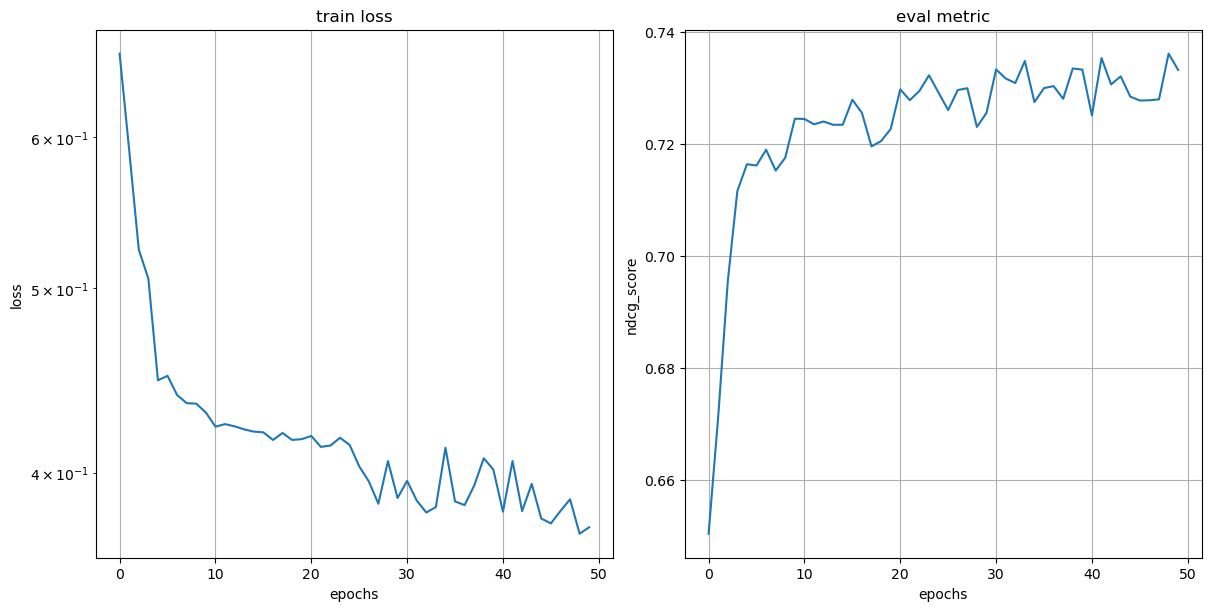

In [10]:
plot_loss_and_metric(train_loss=losses[0], metric = losses[1],  name = 'loss and metric for lin_model_1')


In [11]:
torch.save(model, 'lin_model_1')